### Imports

In [1]:
# for utils.py
import multiprocessing.pool
from functools import partial
import os

# for vgg.py
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf

# for decoder.py
from keras.layers import Input, Conv2D, UpSampling2D

# for model.py 
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Input
import keras.backend as K

# for train.py
import imageio
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
import numpy as np

# for evaluate-decoder.py
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# for style.py
import sys

from keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
import numpy as np

/Users/WillLacey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Parameters

In [14]:
# for vgg
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

WEIGHTS_PATH = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')

# for model.py
LAMBDA=1

# for train.py 
TRAIN_PATH = 'data/input/train'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 4
epochs = 2
target_layer = 1 # also for evaluate-decoder
image_path = "data/input/content.png"
preview_dir_path = "data/output"

# for evaluate-decoder.py
DECODER_PATH = 'models/first_decoder_1.h5'
INPUT_IMG_PATH = content_image_path
OUTPUT_IMG_PATH = 'data/output/out.png'

content_image_path = "data/input/content.png"
style_image_path = "data/input/style.png"
output_image_path = "data/output/style_transfer.png"

### utils.py

In [3]:
def count_num_samples(directory):
    """
    From Keras DirectoryIterator
    """
    return 290
    classes = []
    for subdir in sorted(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, subdir)):
            classes.append(subdir)

    white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm'}
    pool = multiprocessing.pool.ThreadPool()
    function_partial = partial(_count_valid_files_in_directory,
                               white_list_formats=white_list_formats,
                               follow_links=False)
    num_samples = sum(pool.map(function_partial,
                               (os.path.join(directory, subdir)
                                for subdir in classes)))
    pool.close()
    pool.join()
    return num_samples

def convert_float32_to_uint8(img):
    img = img.astype(np.float64) / np.amax(img) 
    img = 255 * img # Now scale by 255
    img = img.astype(np.uint8)
    return img

### vgg.py

In [4]:
def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x


def load_weights(model):
    f = h5py.File(WEIGHTS_PATH)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    f.close()


def VGG19(input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

### decoder.py

In [5]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 1:
        return x

    x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 2:
        return x

    x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 4:
        return x

    x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 5:
        return x

### model.py

In [6]:
def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, input_shape=(256, 256, 3), target_layer=5,
                 decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer

        self.encoder = VGG19(input_shape=input_shape, target_layer=target_layer)
        if decoder_path:
            self.decoder = load_model(decoder_path, compile=False)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Sequential()
        self.model.add(self.encoder)
        self.model.add(self.decoder)

        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                   LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.encoder.output_shape[1:])
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)

    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)

### train.py

In [9]:
def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            if img.shape[0] != batch_size:
                continue

            # (X, y)
            yield (img, img)

    return tuple_gen()

# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        test_img = image.load_img(test_img_path)
        
        # Resizing Image
#         test_img = imresize(test_img, (256, 256, 3))
#         test_img = resize(test_img, (256, 256, 3))
        test_img = test_img.resize((256, 256)) # Assumes using 3 channels I think
    
        test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            
            # Convert image to uint8 then save
            output_img = convert_float32_to_uint8(output_img)
            imageio.imwrite(out_path, output_img)

        self.iteration += 1

gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)

num_samples = count_num_samples(TRAIN_PATH)
steps_per_epoch = num_samples // BATCH_SIZE
print(num_samples)

encoder_decoder = EncoderDecoder(target_layer=target_layer)

callbacks = [OutputPreview(encoder_decoder, image_path, 5000, preview_dir_path)]
encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
        epochs=epochs, callbacks=callbacks)
encoder_decoder.export_decoder()

Found 290 images belonging to 29 classes.
290
Epoch 1/2
 1/72 [..............................] - ETA: 7:34 - loss: 36860190720.0000

KeyboardInterrupt: 

### evaluate-decoder.py

In [12]:
encoder_decoder = EncoderDecoder(decoder_path=DECODER_PATH, target_layer=target_layer)

input_img = image.load_img(INPUT_IMG_PATH)
input_img = input_img.resize((256, 256))
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)

output_img = encoder_decoder.model.predict([input_img])[0]

# Convert image to uint8 then save
output_img = convert_float32_to_uint8(output_img)
imageio.imwrite(OUTPUT_IMG_PATH, output_img)

### style.py

Loading decoders...
Loading VGG...


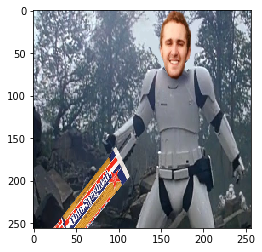

Styling...


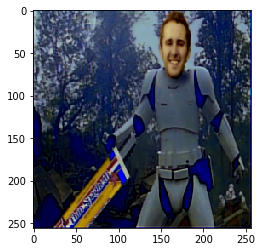

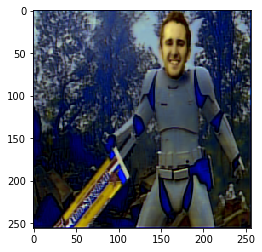

Saving output...
Saved!


In [22]:
def get_vgg_features(vgg, inputs, target_layer):
    output_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1'
    ]

    outputs = [layer.output for layer in vgg.layers
               if layer.name == output_layers[target_layer-1]]
    f = K.function([vgg.input] + [K.learning_phase()], outputs)
    return f([inputs, 1.])


def wct(content, style, alpha=0.6, eps=1e-5):
    '''
    https://github.com/eridgd/WCT-TF/blob/master/ops.py
       Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    # Whitening transform
    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    Ec, wc, _ = np.linalg.svd(fcfc)
    k_c = (wc > 1e-5).sum()
    Dc = np.diag((wc[:k_c]+eps)**-0.5)
    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    # Coloring transform
    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
    Es, ws, _ = np.linalg.svd(fsfs)
    k_s = (ws > 1e-5).sum()
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))
    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
    fcs_hat = fcs_hat + ms

    # Blend transform features with original features
    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

    return np.float32(blended)



img_c = image.load_img(content_image_path)
img_c = img_c.resize((256, 256)) # Assumes using 3 channels I think
img_c = image.img_to_array(img_c)
img_c_shape = img_c.shape
img_c = np.expand_dims(img_c, axis=0)

img_s = image.load_img(style_image_path)
img_s = img_s.resize((256, 256)) # Assumes using 3 channels I think
img_s = image.img_to_array(img_s)
img_s_shape = img_s.shape
img_s = np.expand_dims(img_s, axis=0)

assert img_c_shape == img_s_shape, \
    'Content and style image should be the same shape, %s != %s' \
    % (str(img_c_shape), str(img_s_shape))

input_shape = img_c_shape

print('Loading decoders...')
decoders = {}
decoders[1] = load_model('./models/first_decoder_1.h5', compile=False)
# decoders[2] = load_model('./models/decoder_2.h5')
# decoders[3] = load_model('./models/decoder_3.h5')
# decoders[4] = load_model('./models/decoder_4.h5')
# decoders[5] = load_model('./models/decoder_5.h5')

print('Loading VGG...')
vgg = VGG19(input_shape=input_shape, target_layer=5)

import matplotlib.pyplot as plt

plt.imshow(np.clip(img_c[0] / 255, 0, 1))
plt.show()

print('Styling...')
for i in [1, 1]:
    feats_c = get_vgg_features(vgg, img_c, i)
    feats_s = get_vgg_features(vgg, img_s, i)
    feats_cs = wct(feats_c, feats_s)
    img_c = decoders[i].predict(feats_cs)
    plt.imshow(np.clip(img_c[0] / 255, 0, 1))
    plt.show()

print('Saving output...')
output_img = img_c[0]

output_img = convert_float32_to_uint8(output_img)
imageio.imwrite(output_image_path, output_img)
print('Saved!')